In [1]:
import tensorflow as tf
from tqdm import tqdm
import numpy as np
from transformers import RobertaTokenizer, RobertaConfig, TFRobertaModel
from sklearn.model_selection import train_test_split
import pickle
import random
import sys
import math
from scipy import stats
from scipy.spatial import distance
import random
import os

C:\ProgramData\anaconda3\envs\research\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# Limit GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


In [3]:
base_folder = "data/"
input_file = "hate_norm_combined.pkl"

output_folder = "output_weights/"
output_file = "output_weights"

roberta_model = "roberta-base"

MAX_LENGTH = 128
TEST_SIZE = 0.2
seed = 42

use_attention = True

roberta_dropout = 0.2
lstm_units = 512 # 50
dense_units = 50
lstm_dropout = 0.1
dense_dropout = 0.2
epochs = 10 #(Default 10)
batch_size = 16

def random_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

random_seed(seed)

In [4]:
def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=MAX_LENGTH,
                                       padding='max_length', truncation=True, return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])

    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')


## Define base bert configs
config = RobertaConfig(dropout=roberta_dropout, attention_dropout=roberta_dropout, output_attentions=True)
config.output_hidden_states = False

transformer_model = TFRobertaModel.from_pretrained(roberta_model, config=config, ignore_mismatched_sizes=True)

for layer in transformer_model.layers[:3]:  ## Freeze first 3 layers
    layer.trainable = False

# Defining tokonizer
tokenizer = RobertaTokenizer.from_pretrained(roberta_model, do_lower_case=True, add_special_tokens=True, max_length=MAX_LENGTH, padding=True)

C:\ProgramData\anaconda3\envs\research\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_embeddings.weight', 'roberta.embeddings.position_ids', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.embeddings.token_type_embeddings.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identica

In [5]:
input_ids_in = tf.keras.layers.Input(shape=(MAX_LENGTH, ), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(MAX_LENGTH, ), name='masked_token', dtype='int32')

embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]

X = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(lstm_units, return_sequences=True,
                         dropout=lstm_dropout, recurrent_dropout=lstm_dropout, kernel_initializer='normal')
    )(embedding_layer)

if use_attention:
    X = tf.keras.layers.Attention(use_scale=True)([X, X])  # Use attention.
    
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(dense_units, activation='relu',  kernel_initializer='normal')(X)
X = tf.keras.layers.Dropout(dense_dropout)(X)
X = tf.keras.layers.Dense(1, activation='linear', kernel_initializer='normal')(X)

model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs=X)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc', tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124644864  ['input_token[0][0]',            
 el)                            thPoolingAndCrossAt               'masked_token[0][0]']           
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [11]:
import pydot

def check_graphviz():
    try:
        pydot.Dot.create(pydot.Dot())
        return True
    except OSError:
        return False

# Model plotting function
def plot_model(model):
    if not model.built:
        raise ValueError(
            "This model has not yet been built. "
            "Build the model first by calling `build()` or by calling "
            "the model on a batch of data."
        )

    if not check_graphviz():
        raise RuntimeError(
            "You must install pydot (`pip install pydot`) "
            "and install graphviz "
            "(see instructions at https://graphviz.gitlab.io/download/) "
            "for plot_model to work."
        )
    
    tf.keras.utils.plot_model(
        model,
        show_shapes=False,
        show_dtype=False,
        show_layer_names=True,
        rankdir='TB',
        expand_nested=False,
        dpi=96,
        layer_range=None,
        show_layer_activations=False
    )

plot_model(model)

RuntimeError: You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.

In [6]:
with open(base_folder + input_file, 'rb') as f:
    input_data = pickle.load(f)

intensity_value = []
hate_sentences = []

for i in range(len(input_data)):
    intensity_value.append(int(input_data['Original_Intensity'][i]))
    hate_sentences.append(input_data['Sentence'][i])
    intensity_value.append(int(input_data['Normalized_Intensity'][i]))
    hate_sentences.append(input_data['Normalized_Sentence'][i])

c = list(zip(intensity_value, hate_sentences))
random.shuffle(c)
intensity_value, hate_sentences = zip(*c)

X_tr, X_te, y_tr, y_te = train_test_split(hate_sentences, intensity_value, test_size=TEST_SIZE, random_state=1)

train_input_ids, train_input_masks, train_input_segment = tokenize(X_tr, tokenizer)
test_input_ids, test_input_masks, test_input_segment = tokenize(X_te, tokenizer)

y_tr = np.asarray(y_tr)
y_te = np.asarray(y_te)

  0%|                                                                                         | 0/4843 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\ProgramData\anaconda3\envs\research\lib\site-packages\transformers\tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (

In [7]:
# print(X_tr) # Training sentences
# print("Train input ids: \n", train_input_ids, 
#       "\n\nAttention masks: \n", train_input_masks, 
#       "\n\nToken type ids: \n", train_input_segment) # input_ids, attention_masks, token_type_ids

### TFBertModel with Roberta Embeddings and Tokenizer
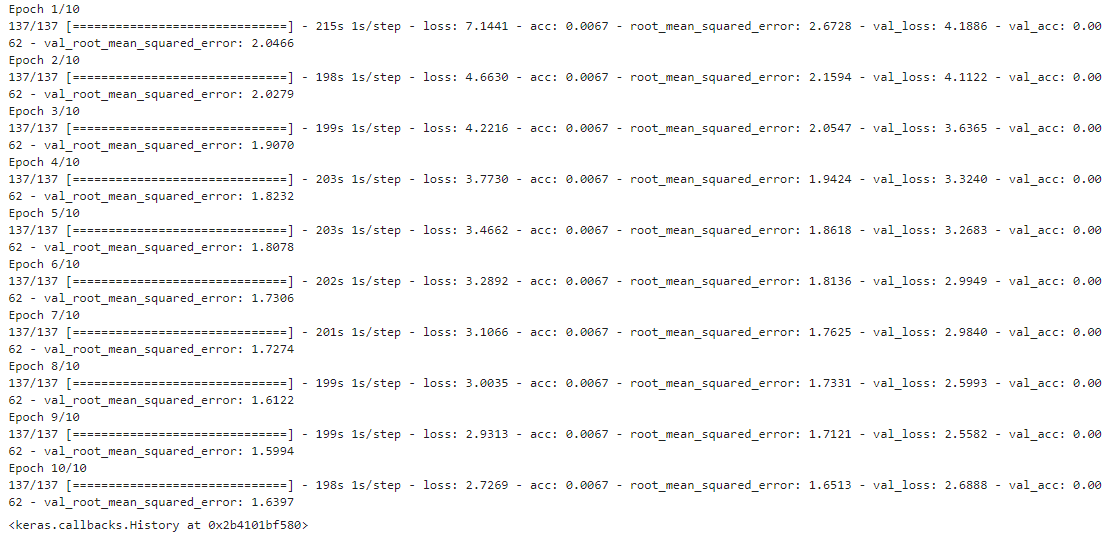


In [8]:
model.fit(x=[train_input_ids, train_input_masks], y=y_tr, epochs=epochs, validation_split=0.1, batch_size=batch_size)

Epoch 1/10
273/273 [==============================] - 402s 1s/step - loss: 4.5938 - acc: 0.0067 - root_mean_squared_error: 2.1433 - val_loss: 3.5903 - val_acc: 0.0062 - val_root_mean_squared_error: 1.8948
Epoch 2/10
273/273 [==============================] - 379s 1s/step - loss: 3.5666 - acc: 0.0067 - root_mean_squared_error: 1.8886 - val_loss: 3.8977 - val_acc: 0.0062 - val_root_mean_squared_error: 1.9742
Epoch 3/10
273/273 [==============================] - 385s 1s/step - loss: 3.3128 - acc: 0.0067 - root_mean_squared_error: 1.8201 - val_loss: 2.5577 - val_acc: 0.0062 - val_root_mean_squared_error: 1.5993
Epoch 4/10
273/273 [==============================] - 381s 1s/step - loss: 3.0445 - acc: 0.0067 - root_mean_squared_error: 1.7448 - val_loss: 2.2822 - val_acc: 0.0062 - val_root_mean_squared_error: 1.5107
Epoch 5/10
273/273 [==============================] - 380s 1s/step - loss: 2.9740 - acc: 0.0067 - root_mean_squared_error: 1.7245 - val_loss: 2.4185 - val_acc: 0.0062 - val_root_me

In [9]:
results = model.evaluate(x=[test_input_ids, test_input_masks], y=y_te)
print(results)

result = model.predict(x=[test_input_ids, test_input_masks])
result = np.array(result, dtype=np.float64)
result = result.flatten()

38/38 [==============================] - 16s 422ms/step - loss: 2.1382 - acc: 0.0058 - root_mean_squared_error: 1.4623
[2.138231039047241, 0.005780346691608429, 1.4622691869735718]
38/38 [==============================] - 18s 413ms/step


In [10]:
_, _, rmse = results
print("RMSE", rmse)
print("Pearson", stats.pearsonr(result, y_te))
print("Cosine", 1 - distance.cosine(result, y_te))

RMSE 1.4622691869735718
Pearson PearsonRResult(statistic=0.7163100961669393, pvalue=3.651380839278849e-191)
Cosine 0.9698135602815349
